# Bike Sharing Demand
**Forecast use of a city bikeshare system**

# 1. EDA

## 1.1 Load Datasets

In [17]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime

In [4]:
# Import dataset
df_train = pd.read_csv("data/train.csv", index_col="datetime", parse_dates=True)
df_test = pd.read_csv("data/test.csv", index_col="datetime", parse_dates=True)
df = pd.concat([df_train, df_test], sort=True)
print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)
print("Full shape:", df.shape)
df_train.head()

Train shape: (10886, 11)
Test shape: (6493, 8)
Full shape: (17379, 11)


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


**Data Description**:
- *datetime*: hourly date + timestamp
- *season*:
    - 1 = spring
    - 2 = summer
    - 3 = fall
    - 4 = winter
- *holiday*: wheter the day is considered a holiday
- *workingday*: whether the day is neither a weekend nor holiday
- *weather*: 
    - 1 = Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2 = Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3 = Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4 = Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- *temp*: temperature in Celsius
- *atemp*: "feels like" temperature in Celsius
- *humidity*: relative humidity
- *windspeed*: wind speed
- *casual*: number of non-registered user rentals initiated
- *registered*: number of registered user rentals initiated
- *count*: number of total rentals

In [3]:
# Let's check for descriptive statistics
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17379 entries, 2011-01-01 00:00:00 to 2012-12-31 23:00:00
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   atemp       17379 non-null  float64
 1   casual      10886 non-null  float64
 2   count       10886 non-null  float64
 3   holiday     17379 non-null  int64  
 4   humidity    17379 non-null  int64  
 5   registered  10886 non-null  float64
 6   season      17379 non-null  int64  
 7   temp        17379 non-null  float64
 8   weather     17379 non-null  int64  
 9   windspeed   17379 non-null  float64
 10  workingday  17379 non-null  int64  
dtypes: float64(6), int64(5)
memory usage: 1.6 MB


There are no missing values

In [5]:
df.describe()

,atemp,casual,count,holiday,humidity,registered,season,temp,weather,windspeed,workingday
count,17379.000000,10886.000000,10886.000000,17379.000000,17379.000000,10886.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,23.788755,36.021955,191.574132,0.028770,62.722884,155.552177,2.501640,20.376474,1.425283,12.736540,0.682721
std,8.592511,49.960477,181.144454,0.167165,19.292983,151.039033,1.106918,7.894801,0.639357,8.196795,0.465431
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.820000,1.000000,0.000000,0.000000
25%,16.665000,4.000000,42.000000,0.000000,48.000000,36.000000,2.000000,13.940000,1.000000,7.001500,0.000000
50%,24.240000,17.000000,145.000000,0.000000,63.000000,118.000000,3.000000,20.500000,1.000000,12.998000,1.000000
75%,31.060000,49.000000,284.000000,0.000000,78.000000,222.000000,3.000000,27.060000,2.000000,16.997900,1.000000
max,50.000000,367.000000,977.000000,1.000000,100.000000,886.000000,4.000000,41.000000,4.000000,56.996900,1.000000


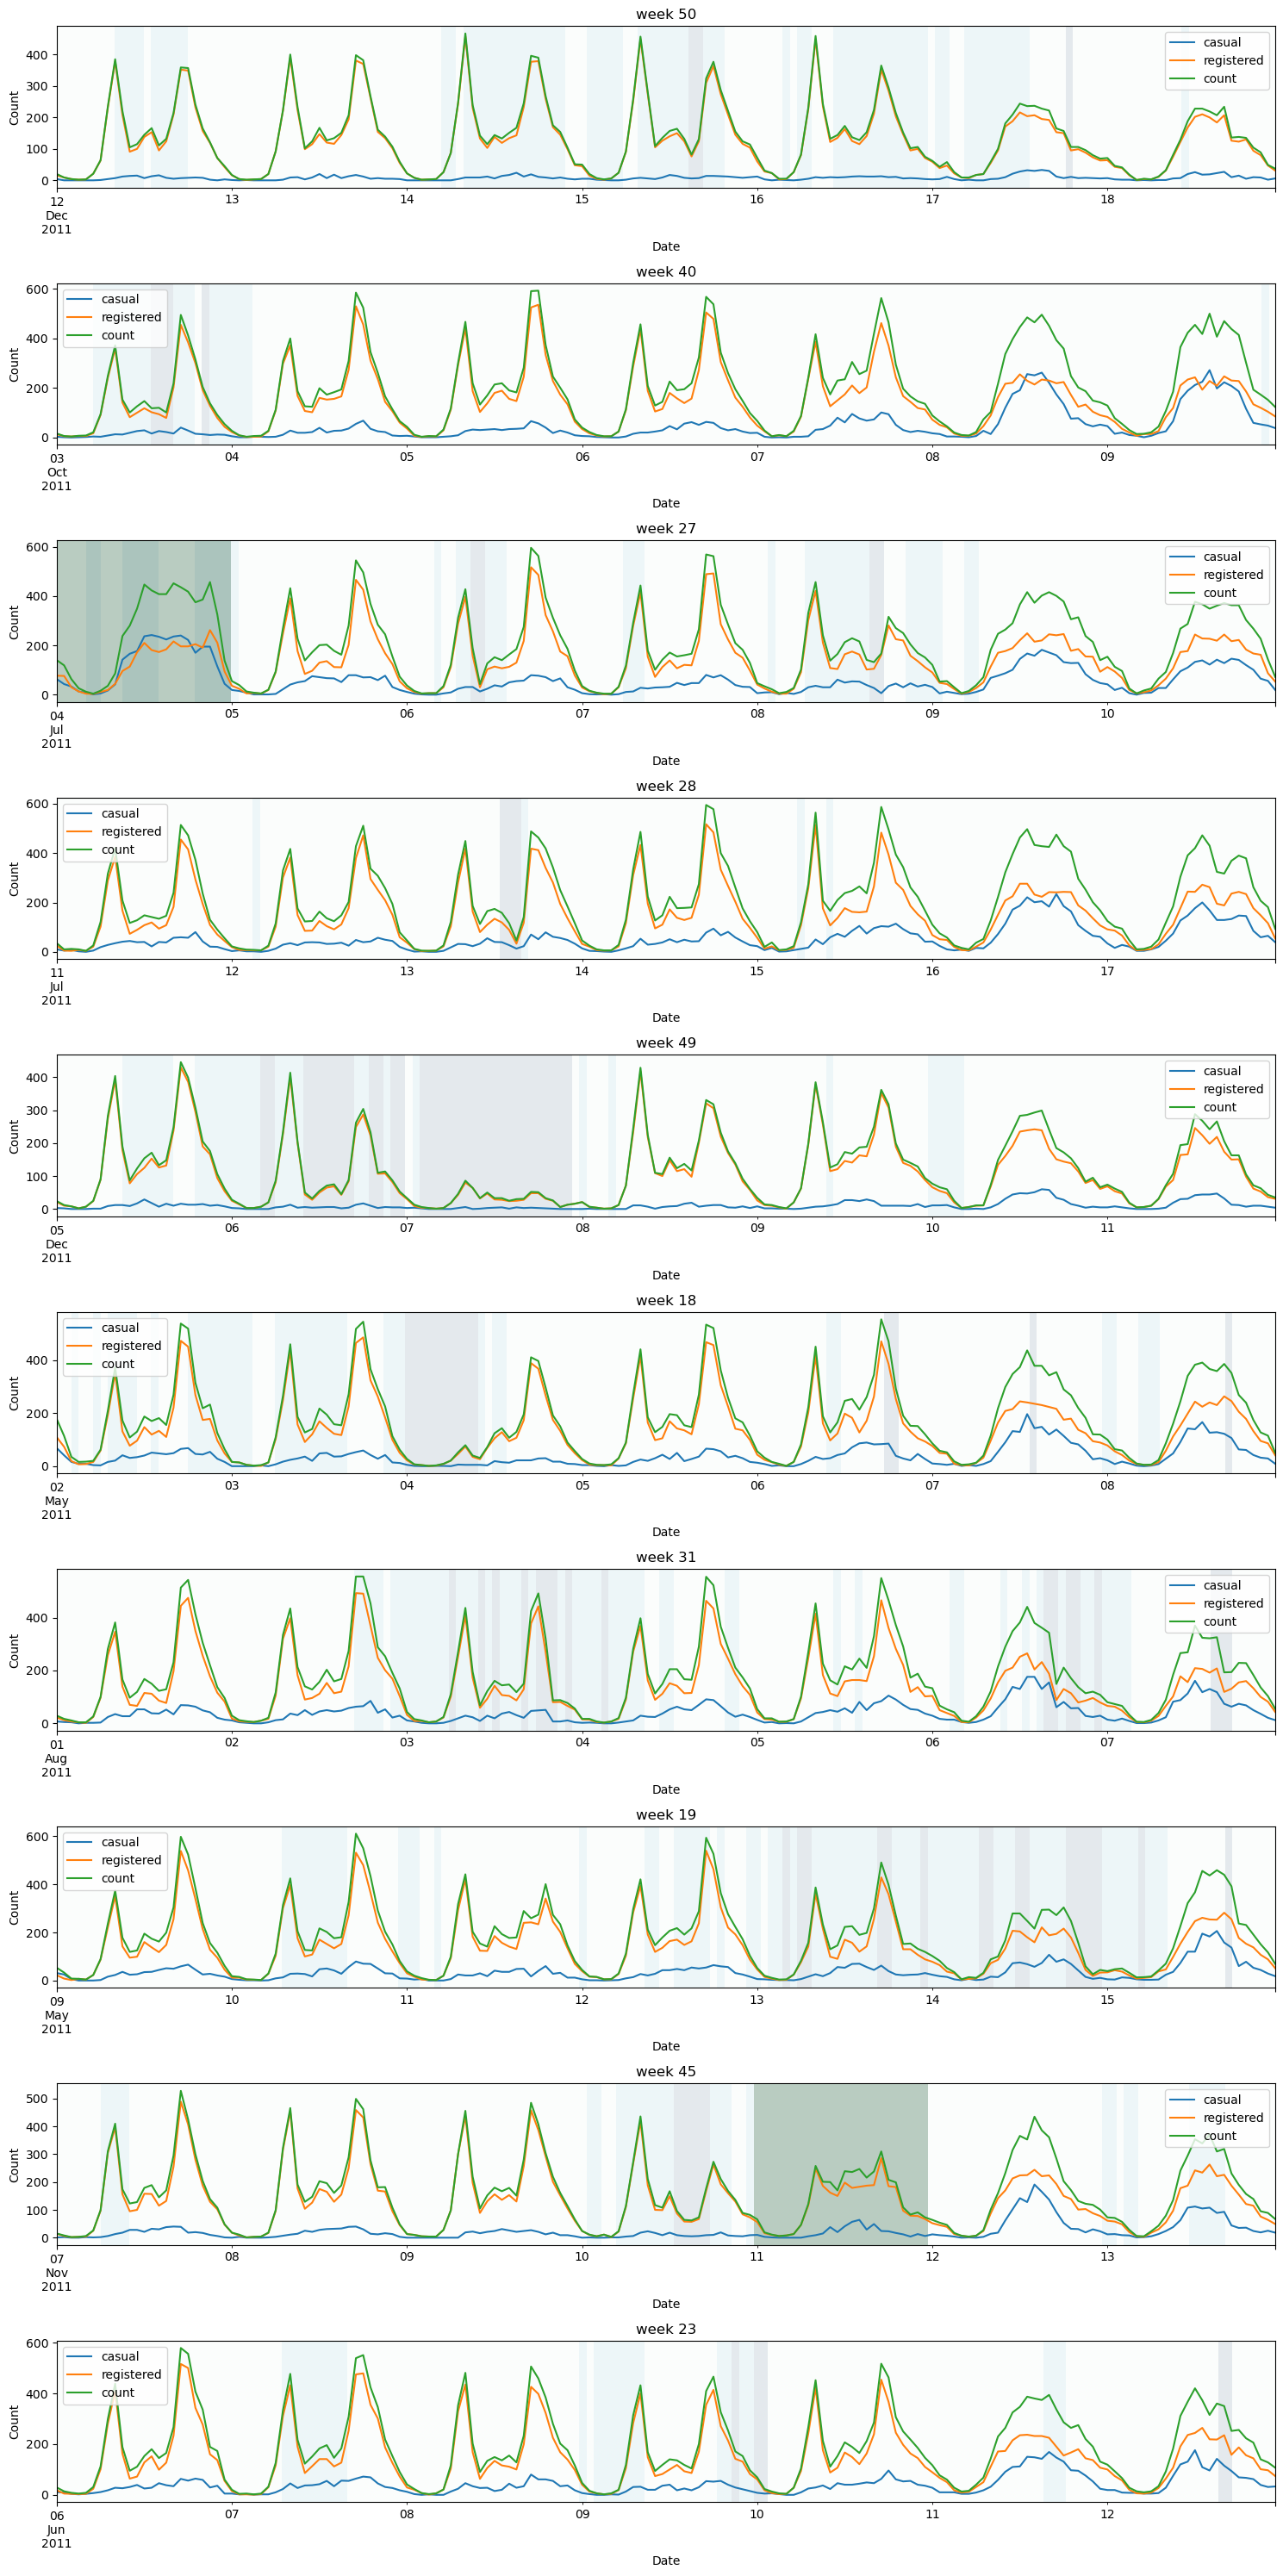

In [66]:
# Let's plot registered, casual and count for some sampled weeks

# Add week of year column
tmp = df_train.copy()
tmp["year"] = tmp.index.isocalendar().year
tmp["weekofyear"] = tmp.index.isocalendar().week
nweeks = 30
np.random.seed(38)
weeks = np.random.choice(tmp[tmp["year"] == 2011]["weekofyear"].unique(), replace=False, size=nweeks)

# Get dfs for plotting
dfs = []
for i, w in enumerate(weeks):
    cond = (tmp["year"] == 2011) & (tmp["weekofyear"] == w)
    if tmp[cond].shape[0] < 7 * 24:
        continue
    else:
        dfs.append(tmp[cond])

# Loop over weeks
fig, axes = plt.subplots(len(dfs), 1, figsize=(15, 30))
axes = axes.flatten()    
for i, dataframe in enumerate(dfs):
    w = dataframe["weekofyear"].unique()[0]
    dataframe[["casual", "registered", "count"]].plot(ax=axes[i], title=f"Week {w}")
    # Add color background to identify holidays
    axes[i].pcolorfast(axes[i].get_xlim(), axes[i].get_ylim(), dataframe[['holiday']].T.values, cmap="Greens", alpha=0.3)
    # Add color background to check weather
    axes[i].pcolorfast(axes[i].get_xlim(), axes[i].get_ylim(), dataframe[['weather']].T.values, cmap="Blues", alpha=0.1)
    axes[i].set_xlabel("Date")
    axes[i].set_ylabel("Count")
plt.tight_layout()    
plt.show()

Few comments on the plots above:
- There are two seasonality in the data: a daily and a weekly seasonality. Day after day the pattern repeats and weekends show a
different behaviour compared to working days.
- During the week, the count is given mostly by the registered users. Casual users increase in the weekends.
- Holidays show a different pattern that resembles the weekends' one.
- Weather seems to influence the count pattern. To severe weather (week 49) corresponds a drop in count. In general, when the weather is not good, a reduction in the number of count is observed.
- It is not clear how much season influences count, we will try to determine this better looking at correlation or dedicated plots.
- It seems that in December, the number of casual users drops.

Let's dig more into the data by plotting distributions.

In [67]:
df.columns

Index(['atemp', 'casual', 'count', 'holiday', 'humidity', 'registered',
       'season', 'temp', 'weather', 'windspeed', 'workingday'],
      dtype='object')

Could not plot column weather, value 4. Exception: `dataset` input should have multiple elements.


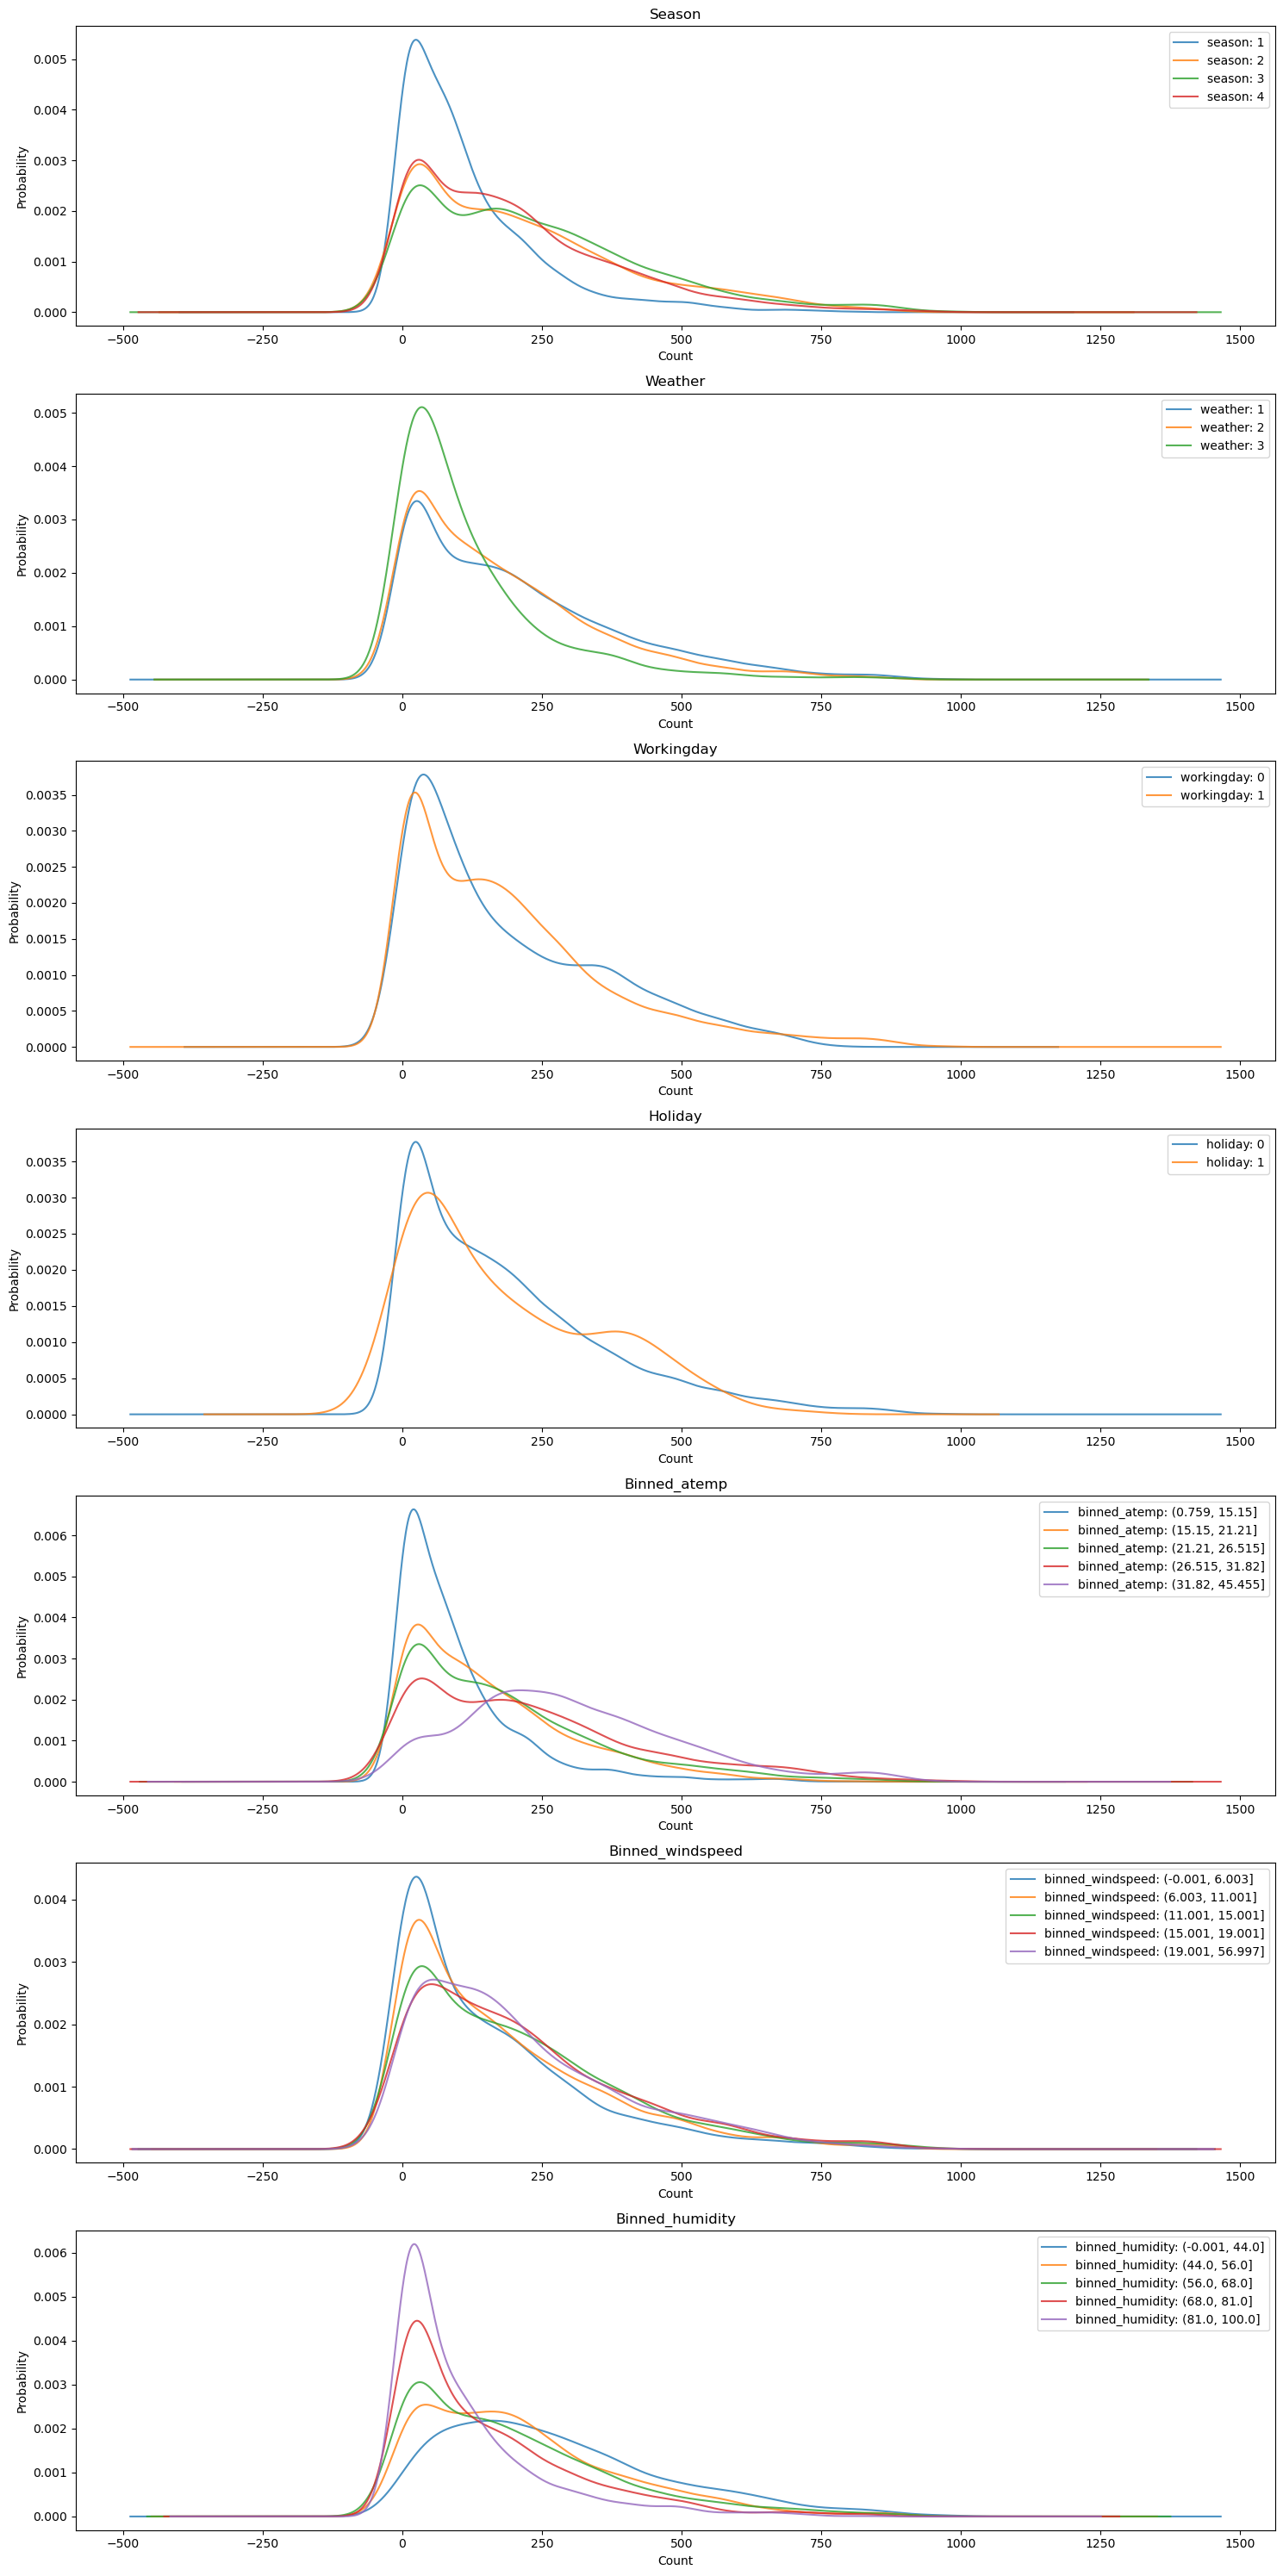

In [95]:
# Distributions
# count per season
# count per weather
# count per workingday
# count per holiday
# count per binned atemp
# count per binned windspeed
# count per binned humidity

# Make tmp df
tmp = df_train.copy()

# Add bin columns
tmp["binned_atemp"] = pd.qcut(x=tmp["atemp"], q=5)
tmp["binned_windspeed"] = pd.qcut(x=tmp["windspeed"], q=5)
tmp["binned_humidity"] = pd.qcut(x=tmp["humidity"], q=5)

# Add week of year column
cols = ["season", "weather", "workingday", "holiday", "binned_atemp", "binned_windspeed", "binned_humidity"]
fig, axes = plt.subplots(len(cols), 1, figsize=(15,30))
axes = axes.flatten()
for i, c in enumerate(cols):
    for uv in tmp[c].sort_values(ascending=True).unique():
        # weights = np.ones(len(df_train[df_train[c] == uv])) / len(df_train[df_train[c] == uv])
        # df_train[df_train[c] == uv]["count"].plot.hist(ax=axes[i], alpha=0.3, weights=weights, bins=20, label=f"{c}: {uv}")
        try:
            tmp[tmp[c] == uv]["count"].plot.kde(ax=axes[i], alpha=0.8, label=f"{c}: {uv}")
        except Exception as e:
            print(f"Could not plot column {c}, value {uv}. Exception: {e}")
        axes[i].set_title(c.capitalize())
        axes[i].set_ylabel("Probability")
        axes[i].set_xlabel("Count")
        axes[i].legend(loc=1)
plt.tight_layout()
plt.show()

Comments on the distributions above:
- season 1 shows a different distribution compared to the other seasons, answering to previous doubts we had in this regard.
- to severe weather corresponds a drop in count.
- working days and weekends show different distributions.
- holidays show a different distribution than other days. In particular there is a bump around count in the range 400-450.
- when the perceived temperature is low, there is a drop in count. Conversely, at high temperatures correspond an increase in count.
- to low windspeed corresponds a lower number of count. This is counterintuitive, maybe it is linked to how the wind change during the day. For instance, its speed might be higher in the afternoon when people usually rent bikes and slow down at night when no one is using the bike sharing system.
- Looking at humidity distributions, things become intuitive again with a drop in count when the humidity is high.